# Homework2

## Set up the machine

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras.preprocessing.image import ImageDataGenerator

# Load data
import os
from google.colab import drive

# Visualize data
import matplotlib.pyplot as plt

# Neural network
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import backend as K
from keras import optimizers

# Evaluate model
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s\n" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Visualize information about the VM in which the code is executed

# Find disk space and RAM space
!df -h
!free -m

#What OS is your VM using:
print("")
!cat /etc/os-release

Tensorflow version 2.4.0
Keras version 2.4.3

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   36G  48% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   34G   41G  46% /opt/bin
tmpfs           6.4G   16K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            69G   35G   35G  51% /content/drive
              total        used        free      shared  buff/cache   available
Mem:          13021        3324        5807          14        3888       10319
Swap:             0           0           0

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL=

## Prepare dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5893 images belonging to 8 classes.
Found 2529 images belonging to 8 classes.
Image input (256, 256, 3)
Classes: ['Olives_jar', 'Oranges', 'Push_Brooms', 'juice_carton', 'plastic_fork', 'serving_tray', 'snacks_Seeds', 'teacup']
Loaded 5893 training samples from 8 classes.
Loaded 2529 test samples from 8 classes.
Push_Brooms


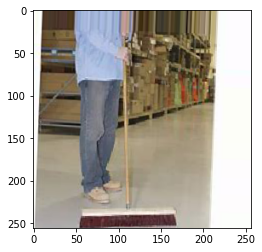

serving_tray


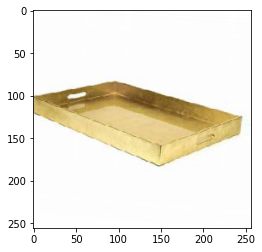

teacup


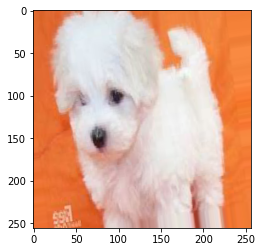

In [ ]:
# State some needed parameters
batch_size = 35
image_height = 256
image_width = 256

# Take data from drive
drive.mount('/content/drive')
#data_dir = '/content/drive/MyDrive/Homework_2_Dataset'

# Split data into train set and test set (to do only once)
#!pip install split-folders

#import splitfolders
#splitfolders.ratio('/content/drive/My Drive/Homework_2_Dataset/', output='/content/drive/My Drive/Homework_2_Dataset_Split/', seed=1337, ratio=(.7, .3), group_prefix=None)
#print('Dataset split')

train_set_dir = '/content/drive/My Drive/Homework_2_Dataset_Split/train'
test_set_dir = '/content/drive/My Drive/Homework_2_Dataset_Split/val'


# State some needed parameters
batch_size = 35
image_height = 256
image_width = 256

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

# Train set
train_generator = train_datagen.flow_from_directory(
    directory=train_set_dir,
    target_size=(image_width, image_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

# Test set
test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_set_dir,
    target_size=(image_width, image_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

# Show sample 
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()


## Define model 
### LeNet

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, image_width, image_height)
else:
    input_shape = (image_width, image_height, 3)

def LeNet(input_shape, num_classes):
    
    print('\nLeNet model')
    model = Sequential()
    
    print('\tC1: Convolutional 6 kernels 5x5')
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding='same'))
    print('\tS2: Average Pooling 2x2 stride 2x2')
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    print('\tC3: Convolutional 16 kernels 5x5')
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    print('\tS4: Average Pooling 2x2 stride 2x2')
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    print('\tC5: Convolutional 120 kernels 5x5')
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(Flatten())
    print('\tF6: Fully connected, 84 units')
    model.add(Dense(84, activation='tanh'))
    print('\tF7: Fully connected, 10 units')
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    return model
 
# create the model
model = LeNet(input_shape,num_classes)
model.summary()


LeNet model
	C1: Convolutional 6 kernels 5x5
	S2: Average Pooling 2x2 stride 2x2
	C3: Convolutional 16 kernels 5x5
	S4: Average Pooling 2x2 stride 2x2
	C5: Convolutional 120 kernels 5x5
	F6: Fully connected, 84 units
	F7: Fully connected, 10 units
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 120)       48120     
_____

### AlexNet

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, image_width, image_height)
else:
    input_shape = (image_width, image_height, 3)

def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 123, 62, 96)       34944     
_________________________________________________________________
activation_9 (Activation)    (None, 123, 62, 96)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 31, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 61, 31, 96)        384       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 51, 21, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 51, 21, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 10, 256)      

## Train the model

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1
epochs = 10
try:
    history = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/10
168/168 [==============================] - 95s 556ms/step - loss: 3.1836 - accuracy: 0.3223 - val_loss: 4.4659 - val_accuracy: 0.1344
Epoch 2/10
168/168 [==============================] - 92s 549ms/step - loss: 2.7611 - accuracy: 0.4554 - val_loss: 3.6237 - val_accuracy: 0.2444
Epoch 3/10
168/168 [==============================] - 92s 549ms/step - loss: 2.6145 - accuracy: 0.4847 - val_loss: 4.9168 - val_accuracy: 0.3270
Epoch 4/10
168/168 [==============================] - 92s 547ms/step - loss: 2.5142 - accuracy: 0.5122 - val_loss: 2.3625 - val_accuracy: 0.5749
Epoch 5/10
168/168 [==============================] - 92s 548ms/step - loss: 2.4544 - accuracy: 0.5307 - val_loss: 3.3404 - val_accuracy: 0.4500
Epoch 6/10
168/168 [==============================] - 92s 548ms/step - loss: 2.3928 - accuracy: 0.5466 - val_loss: 2.8823 - val_accuracy: 0.5560
Epoch 7/10
168/168 [==============================] - 92s 545ms/step - loss: 2.2942 - accuracy: 0.5721 - val_loss: 2.3520 - val_ac

### Save model

In [ ]:
model_dir = '/content/drive/MyDrive/Homework_2_Dataset'
matricola = '1759992'
filename = os.path.join(model_dir, '%s.h5' %matricola)
model.save(filename)
print("Model saved")


Model saved


## Evaluate model

In [ ]:
# Accuracy on test set
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f\n' %acc)

# Precision, recall, F-score
preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

# Confusion matrix
cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

73/73 [==============================] - 7s 99ms/step - loss: 5.4449 - accuracy: 0.2503
Test loss: 5.444855
Test accuracy: 0.250297

73/73 [==============================] - 7s 98ms/step
              precision    recall  f1-score   support

  Olives_jar      0.780     0.260     0.390       354
     Oranges      0.703     0.385     0.498       301
 Push_Brooms      0.462     0.041     0.075       292
juice_carton      0.155     0.935     0.266       325
plastic_fork      0.207     0.155     0.177       226
serving_tray      0.909     0.058     0.110       343
snacks_Seeds      0.818     0.148     0.251       364
      teacup      0.000     0.000     0.000       324

    accuracy                          0.250      2529
   macro avg      0.504     0.248     0.221      2529
weighted avg      0.526     0.250     0.224      2529

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
teacup           ->  juice_carton      	

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot results

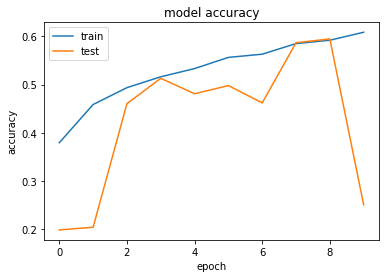

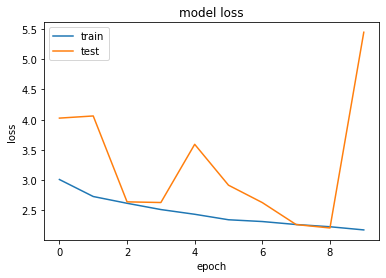

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()